In [1]:
# --------------------------
# Source and reference
#   https://github.com/udacity/CarND-Semantic-Segmentation
#   https://gist.github.com/lianyi/a5ba8d84f5b68401c2313b05e020b062
#   https://medium.com/nanonets/how-to-do-image-segmentation-using-deep-learning-c673cc5862ef
# --------------------------

import tensorflow as tf
import warnings
import helper

# --------------------------
# USER-SPECIFIED DATA
# --------------------------

# Tune these parameters

NUMBER_OF_CLASSES = 2
IMAGE_SHAPE = (352, 1216)
EPOCHS = 5
BATCH_SIZE = 1
DROPOUT = 0.75
VALIDATION_SIZE = 45

print_once = True

# Specify these directory paths

data_dir = './data'
runs_dir = './runs'
training_dir = './data/data_road/training'
testing_dir = './data/data_road/testing'
vgg_path = './data/vgg'

# --------------------------
# Check for a GPU
# --------------------------

#
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

# --------------------------
# PLACEHOLDER TENSORS & SESSION
# --------------------------

correct_label = tf.placeholder(tf.float32, [None, IMAGE_SHAPE[0], IMAGE_SHAPE[1], NUMBER_OF_CLASSES])
learning_rate = tf.placeholder(tf.float32)
keep_prob = tf.placeholder(tf.float32)
global_session = None

# --------------------------
# HELPER FUNCTIONS
# --------------------------

import re
import random
import numpy as np
import os.path
import scipy.misc
import imageio
import shutil
import zipfile
import time
import datetime
import tensorflow as tf
from glob import glob
from urllib.request import urlretrieve
from tqdm import tqdm
import matplotlib.pyplot as plt
       
def create_batches(images_dir="", fg_color = [255, 255, 255], batch_size=1, check_once = True, check_always=False):
    batch_of_images = []
    batch_of_labels = []
    batch_of_image_file_paths = []
    if images_dir == "":
        print("Image directory not specified!")
        return np.array(batch_of_images), np.array(batch_of_labels)
    
    image_paths = glob(os.path.join(images_dir, 'image', '*.png'))
    label_paths = {
        re.sub(r'_road_', '_', os.path.basename(path)): path
        for path in glob(os.path.join(images_dir, 'gt_image', '*_road_*.png'))}
    
    if len(label_paths) == 0:
        print("Labels directory is empty!")
        return np.array(batch_of_images), np.array(batch_of_labels)
    
    image_file_count = 0
    random.shuffle(image_paths)
    for batch_i in range(0, len(image_paths), batch_size):
    #for batch_i in range(0, 10, batch_size):
        if batch_size > 1: print("Processing batch #", batch_i)
        images = []
        labels = []
        image_file_paths = []
        for image_file in image_paths[batch_i:batch_i+batch_size]:
            print("\tProcessing image #", image_file_count)
            # append image file name in array
            image_file_paths.append(os.path.basename(image_file))
            # get gt file corresponding to image file
            gt_image_file = label_paths[os.path.basename(image_file)]
            # read image file
            image = scipy.misc.imread(image_file)
            images.append(image)
            # read gt file create labels comprising of gt and bg
            gt_image = scipy.misc.imread(gt_image_file)
            gt_fg = np.all(gt_image == fg_color, axis=2)
            gt_fg = gt_fg.reshape(*gt_fg.shape, 1)
            label = np.concatenate((gt_fg, np.invert(gt_fg)), axis=2)
            labels.append(label)
            # for checking only
            if check_once or check_always:
                print("\tImage shape   :", image.shape)
                print("\tGT image shape:", gt_image.shape)
                print("\tLabel shape   :", label.shape)
                # check colors in GT image
                label_colors = {}
                for x in range(gt_image.shape[0]):
                    for y in range(gt_image.shape[1]):
                        color = gt_image[x, y]
                        color_string = "(" + str(color[0]) + ", " + str(color[1]) + ", " + str(color[2]) + ")"
                        if color_string not in label_colors:
                            label_colors[color_string] = 1
                        else:
                            label_colors[color_string] += 1
                print("\tLabel colors :")
                count = 1
                for key in label_colors.keys():
                    print("\t  Color #", count, ": ", key, "occurs", label_colors[key], "times")
                    count += 1
                # check count of gt and bg pixels
                print("\tFG sum        :", np.sum(label[:, :, 0]))
                print("\tBG sum        :", np.sum(label[:, :, 1]))
                print("\tGT sum        :", np.sum(label), "\n")
                check_once = False
            image_file_count += 1
            # add to batch
            batch_of_images.append(images)
            batch_of_labels.append(labels)
            batch_of_image_file_paths.append(image_file_paths)
    print("Total files processed:", image_file_count)
    # convert labels to numpy array
    return np.array(batch_of_images), np.array(batch_of_labels), batch_of_image_file_paths

def load_vgg(sess, vgg_path):
    # load the model and weights
    model = tf.saved_model.loader.load(sess, ['vgg16'], vgg_path)

    # Get Tensors to be returned from graph
    graph = tf.get_default_graph()
    image_input_layer = graph.get_tensor_by_name('image_input:0')
    keep_prob = graph.get_tensor_by_name('keep_prob:0')
    layer3 = graph.get_tensor_by_name('layer3_out:0')
    layer4 = graph.get_tensor_by_name('layer4_out:0')
    layer7 = graph.get_tensor_by_name('layer7_out:0')

    return image_input_layer, keep_prob, layer3, layer4, layer7, graph

def show_progress(current_iteration, total_iterations, operation_name=""):
    if total_iterations > 1:
        progress = int(100 * (current_iteration % total_iterations) / (total_iterations - 1))
        status = operation_name + " " + str(current_iteration + 1) + " " + "." * progress + " " + str(progress) + "%"
        print (status, end="\r")

# --------------------------
# MODEL FUNCTIONS
# --------------------------

def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, NUMBER_OF_CLASSES):
    # Use a shorter variable name for simplicity
    layer3, layer4, layer7 = vgg_layer3_out, vgg_layer4_out, vgg_layer7_out

    # Apply 1x1 convolution in place of fully connected layer
    fcn8 = tf.layers.conv2d(layer7, filters=NUMBER_OF_CLASSES, kernel_size=1, name="fcn8")

    # Upsample fcn8 with size depth=(4096?) to match size of layer 4 so that we can add skip connection with 4th layer
    fcn9 = tf.layers.conv2d_transpose(fcn8, filters=layer4.get_shape().as_list()[-1],
                                      kernel_size=4, strides=(2, 2), padding='SAME', name="fcn9")

    # Add a skip connection between current final layer fcn8 and 4th layer
    fcn9_skip_connected = tf.add(fcn9, layer4, name="fcn9_plus_vgg_layer4")

    # Upsample again
    fcn10 = tf.layers.conv2d_transpose(fcn9_skip_connected, filters=layer3.get_shape().as_list()[-1],
                                       kernel_size=4, strides=(2, 2), padding='SAME', name="fcn10_conv2d")

    # Add skip connection
    fcn10_skip_connected = tf.add(fcn10, layer3, name="fcn10_plus_vgg_layer3")

    # Upsample again
    fcn11 = tf.layers.conv2d_transpose(fcn10_skip_connected, filters=NUMBER_OF_CLASSES,
                                       kernel_size=16, strides=(8, 8), padding='SAME', name="fcn11")

    return fcn11

def optimize(nn_last_layer, correct_label, learning_rate, NUMBER_OF_CLASSES, graph):
    
    # Reshape 4D tensors to 2D, each row represents a pixel, each column a class
    logits = tf.reshape(nn_last_layer, (-1, NUMBER_OF_CLASSES), name="fcn_logits")
    correct_label_reshaped = tf.reshape(correct_label, (-1, NUMBER_OF_CLASSES))

    # Calculate distance from actual labels using cross entropy
    with graph.as_default():
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=correct_label_reshaped[:])
    # Take mean for total loss
    loss_op = tf.reduce_mean(cross_entropy, name="fcn_loss")

    # The model implements this operation to find the weights/parameters that would yield correct pixel labels
    train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss_op, name="fcn_train_op")

    return logits, train_op, loss_op

def train_nn(sess, epochs, batch_size, learning_rate, image_shape,
             training_images, training_labels, validation_images, validation_labels,
             logits, train_op, cross_entropy_loss,
             image_input_layer, correct_label, keep_prob):
    keep_prob_value = 0.5
    learning_rate_value = 0.001
    num_of_batches = len(training_images)
    num_of_validation_images = len(validation_images)
    
    start_time = datetime.datetime.now()
    print("\nStart time          : ", start_time)
    # create variables for stats
    epoch_start_time = start_time
    sum_of_epoch_times = 0.0
    
    # for plotting graphs
    collection_of_average_IoU_per_epoch = []
    collection_of_train_loss_per_epoch = []
    collection_of_average_validation_IoU_per_epoch = []
    collection_of_validation_loss_per_epoch = []
    
    for current_epoch in range(epochs):
        print("")                           
        print("=================================================")
        print("Epoch #", (current_epoch + 1), "in progress")
        print("Epoch start time    : ", epoch_start_time)
        train_loss = 0
        validation_loss = 0
        average_IoU_epoch = 0
        average_validation_IoU_epoch = 0
        
        # training loop
        for i in range(num_of_batches):   
            # run session to get predictions
            im_softmax, _, loss = sess.run([tf.nn.softmax(logits), train_op, cross_entropy_loss],
                               feed_dict={
                                   image_input_layer: training_images[i],
                                   correct_label: training_labels[i],
                                   keep_prob: keep_prob_value,
                                   learning_rate: learning_rate_value})
            train_loss += loss
            # show progress bar
            show_progress(
                current_iteration=i,
                total_iterations=num_of_batches,
                operation_name="training  ")
            # foreground is at index 0 of softmax
            im_softmax = im_softmax[:, 0].reshape(image_shape[0], image_shape[1])
            segmentation = (im_softmax > 0.5)
            segmentation = segmentation.reshape(image_shape[0], image_shape[1], 1)
            # calculate IoU
            only_segmentation = np.sum(segmentation)
            gt = training_labels[i][0][:, :, 0]
            only_gt = np.sum(gt)
            intersection = segmentation.astype(int).ravel().dot(gt.astype(int).ravel())
            union = only_segmentation + only_gt - intersection
            IoU = round(100.0 * intersection / union, 2)
            average_IoU_epoch += IoU
            # add to collections
            collection_of_average_IoU_per_epoch.append(IoU)
            collection_of_train_loss_per_epoch.append(loss)
        
        print("")
        # validation loop
        for i in range (num_of_validation_images):
            # read image, ground truth and filename
            image = validation_images[i][0]
            gt = validation_labels[i][0][:, :, 0]
            
            # run session to get predictions
            im_softmax, _, loss = sess.run([tf.nn.softmax(logits), train_op, cross_entropy_loss],
                                           feed_dict={
                                               image_input_layer: validation_images[i],
                                               correct_label: validation_labels[i],
                                               keep_prob: 1.0,
                                               learning_rate: learning_rate_value})
            validation_loss += loss
            show_progress(
                current_iteration=i,
                total_iterations=num_of_validation_images,
                operation_name="validation")
            # foreground is at index 0 of softmax
            im_softmax = im_softmax[:, 0].reshape(image_shape[0], image_shape[1])
            segmentation = (im_softmax > 0.5)
            segmentation = segmentation.reshape(image_shape[0], image_shape[1], 1)
            # calculate IoU
            only_segmentation = np.sum(segmentation)
            only_gt = np.sum(gt)
            intersection = segmentation.astype(int).ravel().dot(gt.astype(int).ravel())
            union = only_segmentation + only_gt - intersection
            IoU = round(100.0 * intersection / union, 2)
            average_validation_IoU_epoch += IoU
            # add to collections
            collection_of_average_validation_IoU_per_epoch.append(IoU)
            collection_of_validation_loss_per_epoch.append(loss)
        
        # stats for current epoch
        train_loss = round(train_loss, 2)
        validation_loss = round(validation_loss, 2)
        average_IoU_epoch = round(average_IoU_epoch/num_of_batches, 2)
        average_validation_IoU_epoch = round(average_IoU_epoch/num_of_validation_images, 2)
        epoch_stop_time = datetime.datetime.now()
        epoch_time = round((epoch_stop_time - epoch_start_time).total_seconds(), 2)
        sum_of_epoch_times = sum_of_epoch_times + epoch_time
        avg_iter_time = round(epoch_time * 1000 / num_of_batches, 2)
        epoch_start_time = epoch_stop_time
        # add to collections
        #collection_of_average_IoU_per_epoch.append(average_IoU_epoch)
        #collection_of_train_loss_per_epoch.append(train_loss)
        #collection_of_average_validation_IoU_per_epoch.append(average_validation_IoU_epoch)
        #collection_of_validation_loss_per_epoch.append(validation_loss)
        # display stats
        print("")
        print("Epoch stop time       : ", epoch_stop_time)
        print("Epochs completed      : ", current_epoch+1)
        print("Epoch time            : ", epoch_time, " seconds")
        print("Avg. iteration time   : ", avg_iter_time, " ms")
        print("Train loss            : ", train_loss)
        print("Average train IoU     : ", average_IoU_epoch, " %")
        print("Validation loss       : ", validation_loss)
        print("Average validation IoU: ", average_validation_IoU_epoch, " %")
        print("=================================================")
    training_output = []
    training_output.append(collection_of_average_IoU_per_epoch)
    training_output.append(collection_of_train_loss_per_epoch)
    training_output.append(collection_of_average_validation_IoU_per_epoch)
    training_output.append(collection_of_validation_loss_per_epoch)
    return training_output 

# --------------------------
# MAIN
# --------------------------
#if __name__ == '__main__':

# Download pretrained vgg model
helper.maybe_download_pretrained_vgg(data_dir)

# create batches from dataset
batch_size = 1
fg_color = np.array([255, 0, 255])
print("\nCreating training batch   ...")
training_images, training_labels, _ = create_batches(
    images_dir = training_dir,
    fg_color = fg_color,
    batch_size = batch_size,
    check_always = False)
print("\nCreating testing batch    ...")
testing_images, testing_labels, testing_image_file_paths = create_batches(
    images_dir = testing_dir,
    fg_color = fg_color,
    batch_size = batch_size,
    check_always = False)
print("\nCreating validation batch ...")
validation_images, training_images = np.split(training_images, [VALIDATION_SIZE])
validation_labels, training_labels = np.split(training_labels, [VALIDATION_SIZE])

print("")
print("Training batch of images created  :", training_images.shape)
print("Training batch of labels created  :", training_labels.shape)
print("")
print("Validation batch of images created:", validation_images.shape)
print("Validation batch of labels created:", validation_labels.shape)
print("")
print("Testing batch of images created   :", testing_images.shape)
print("Testing batch of labels created   :", testing_labels.shape)

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Default GPU Device: /device:GPU:0

Creating training batch   ...
	Processing image # 0


/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:106: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:109: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


	Image shape   : (352, 1216, 3)
	GT image shape: (352, 1216, 3)
	Label shape   : (352, 1216, 2)
	Label colors :
	  Color # 1 :  (255, 0, 0) occurs 324875 times
	  Color # 2 :  (0, 0, 0) occurs 6399 times
	  Color # 3 :  (255, 0, 255) occurs 96758 times
	FG sum        : 96758
	BG sum        : 331274
	GT sum        : 428032 

	Processing image # 1
	Processing image # 2
	Processing image # 3
	Processing image # 4
	Processing image # 5
	Processing image # 6
	Processing image # 7
	Processing image # 8
	Processing image # 9
	Processing image # 10
	Processing image # 11
	Processing image # 12
	Processing image # 13
	Processing image # 14
	Processing image # 15
	Processing image # 16
	Processing image # 17
	Processing image # 18
	Processing image # 19
	Processing image # 20
	Processing image # 21
	Processing image # 22
	Processing image # 23
	Processing image # 24
	Processing image # 25
	Processing image # 26
	Processing image # 27
	Processing image # 28
	Processing image # 29
	Processing imag

In [2]:
global_session = tf.Session()
#with tf.Session() as session:

# Returns the three layers, keep probability and input layer from the vgg architecture
image_input_layer, keep_prob, layer3, layer4, layer7, graph = load_vgg(global_session, vgg_path)

# The resulting network architecture from adding a decoder on top of the given vgg model
model_output = layers(layer3, layer4, layer7, NUMBER_OF_CLASSES)

# Returns the output logits, training operation and cost operation to be used
# - logits: each row represents a pixel, each column a class
# - train_op: function used to get the right parameters to the model to correctly label the pixels
# - cross_entropy_loss: function outputting the cost which we are minimizing, lower cost should yield higher accuracy
logits, train_op, cross_entropy_loss = optimize(model_output, correct_label, learning_rate, NUMBER_OF_CLASSES, graph)

# Initialize all variables
#session.run(tf.global_variables_initializer())
#session.run(tf.local_variables_initializer())
global_session.run(tf.global_variables_initializer())
global_session.run(tf.local_variables_initializer())

print("Model build successful, starting training")

# Train the neural network
train_output = train_nn(global_session, EPOCHS, BATCH_SIZE, learning_rate, IMAGE_SHAPE,
         training_images, training_labels, validation_images, validation_labels,
         logits, train_op, cross_entropy_loss,
         image_input_layer, correct_label, keep_prob)
print("\nTraining Finished!")

INFO:tensorflow:Restoring parameters from ./data/vgg/variables/variables
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Model build successful, starting training

Start time          :  2018-11-28 02:05:23.524018

Epoch # 1 in progress
Epoch start time    :  2018-11-28 02:05:23.524018
training   199 .................................................................................................... 100%
validation 45 .................................................................................................... 100%
Epoch stop time       :  2018-11-28 02:13:21.116433
Epochs completed      :  1
Epoch time            :  477.59  seconds
Avg. iteration time   :  2399.95  ms
Train loss            :  2812.49
Average train IoU     :  21.05  %
Validation loss       :  12.45
Average validation IoU:  0.47  %

Epoch # 2 in progress
Epoch start time 

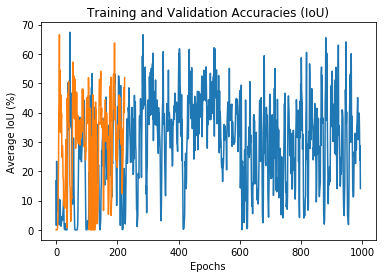

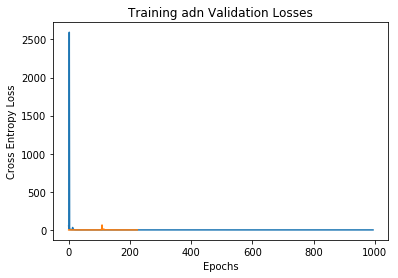

In [3]:
collection_of_average_IoU_per_epoch = train_output[0]
collection_of_train_loss_per_epoch = train_output[1]
collection_of_average_validation_IoU_per_epoch = train_output[2]
collection_of_validation_loss_per_epoch = train_output[3]

# plot training accuracy graph
plt.plot(collection_of_average_IoU_per_epoch) 
plt.plot(collection_of_average_validation_IoU_per_epoch) 
plt.xlabel("Epochs")
plt.ylabel("Average IoU (%)") 
plt.title("Training and Validation Accuracies (IoU)") 
plt.show()

# plot training accuracy graph
plt.plot(collection_of_train_loss_per_epoch)
plt.plot(collection_of_validation_loss_per_epoch)
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss") 
plt.title("Training adn Validation Losses") 
plt.show()

In [ ]:
num_of_testing_images = 1
def save_inference_samples(sess, image_shape, runs_dir,
                           testing_images, testing_labels, testing_image_file_paths,
                           image_input_layer, logits, keep_prob):
    def gen_test_output(sess, image_shape,
                    testing_images, testing_labels, testing_image_file_paths,
                    logits, image_pl, keep_prob):
        """
        Generate test output using the test images
        :param sess: TF session
        :param logits: TF Tensor for the logits
        :param keep_prob: TF Placeholder for the dropout keep robability
        :param image_pl: TF Placeholder for the image placeholder
        :param image_shape: Tuple - Shape of image
        :return: Output for for each test image
        """
        num_of_testing_images = len(testing_images)
        for i in range (num_of_testing_images):
            # read image, ground truth and filename
            image = testing_images[i][0]
            gt = testing_labels[i][0][:, :, 0]
            image_file = testing_image_file_paths[i][0]

            #loss, _ = sess.run([cross_entropy_loss, train_op],
            #                   feed_dict={input_image: X_batch, correct_label: gt_batch,
            #                              keep_prob: keep_prob_value, learning_rate: learning_rate_value})
            #total_loss += loss

            # run session to get predictions
            im_softmax = sess.run(
                [tf.nn.softmax(logits)],
                {keep_prob: 1.0, image_pl: [image]})

            # foreground is at index 0 of softmax
            #im_softmax = im_softmax[0][:, 1].reshape(image_shape[0], image_shape[1])
            im_softmax = im_softmax[0][:, 0].reshape(image_shape[0], image_shape[1])
            segmentation = (im_softmax > 0.5)
            segmentation = segmentation.reshape(image_shape[0], image_shape[1], 1)

            only_segmentation = np.sum(segmentation)
            only_gt = np.sum(gt)
            intersection = segmentation.astype(int).ravel().dot(gt.astype(int).ravel())

            union = only_segmentation + only_gt - intersection
            IoU = round(100.0 * intersection / union, 2)

            print("")
            print("Test image #", i)
            print("\tintersection: ", intersection)
            print("\tonly seg    : ", only_segmentation)
            print("\tonly gt     : ", only_gt)
            print("\tunion       : ", union)
            print("\tIoU         : ", IoU, " %")

            mask = np.dot(segmentation, np.array([[0, 255, 0, 127]]))
            mask = scipy.misc.toimage(mask, mode="RGBA")
            result_image = scipy.misc.toimage(image)
            result_image.paste(mask, box=None, mask=mask)
            #yield os.path.basename(image_file), np.array(result_image)
            yield image_file, np.array(result_image), IoU
    
    # Make folder for current run
    output_dir = os.path.join(runs_dir, str(time.time()))
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)

    # Run NN on test images and save them to HD
    print("Saving test images to: {}".format(output_dir))
    
    image_outputs = gen_test_output(
        sess, image_shape,
        testing_images, testing_labels, testing_image_file_paths,
        logits, image_input_layer, keep_prob)
    
    average_IoU = 0.0
    num_of_test_images = 0
    for name, image, IoU in image_outputs:
        scipy.misc.imsave(os.path.join(output_dir, name), image)
        average_IoU += IoU
        num_of_test_images += 1
    average_IoU = round(average_IoU/num_of_test_images, 2)
    return average_IoU

# Run the model with the test images and save each painted output image (roads painted green)
average_IoU = save_inference_samples(global_session, IMAGE_SHAPE, runs_dir,
                       testing_images, testing_labels, testing_image_file_paths,
                       image_input_layer, logits, keep_prob)
print("")
print("Average IoU: ", average_IoU, "%")

Saving test images to: ./runs/1543373076.0850224

Test image # 0
	intersection:  35007
	only seg    :  69552
	only gt     :  52420
	union       :  86965
	IoU         :  40.25  %


/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:56: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:57: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:79: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.



Test image # 1
	intersection:  45102
	only seg    :  69552
	only gt     :  86841
	union       :  111291
	IoU         :  40.53  %

Test image # 2
	intersection:  37072
	only seg    :  69552
	only gt     :  56227
	union       :  88707
	IoU         :  41.79  %

Test image # 3
	intersection:  44938
	only seg    :  69552
	only gt     :  86483
	union       :  111097
	IoU         :  40.45  %

Test image # 4
	intersection:  40473
	only seg    :  69552
	only gt     :  58967
	union       :  88046
	IoU         :  45.97  %

Test image # 5
	intersection:  32450
	only seg    :  69552
	only gt     :  51631
	union       :  88733
	IoU         :  36.57  %

Test image # 6
	intersection:  36198
	only seg    :  69552
	only gt     :  62887
	union       :  96241
	IoU         :  37.61  %

Test image # 7
	intersection:  45171
	only seg    :  69552
	only gt     :  68458
	union       :  92839
	IoU         :  48.66  %

Test image # 8
	intersection:  41755
	only seg    :  69552
	only gt     :  60541
	union       